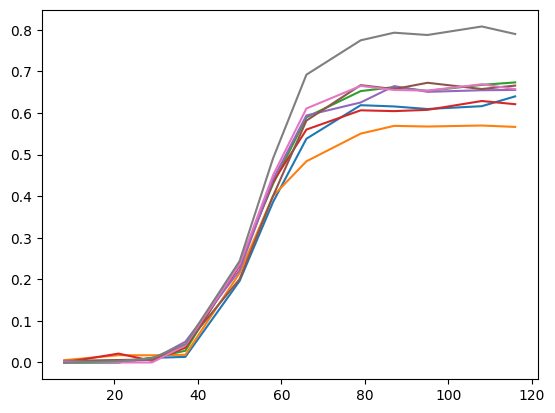

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF
from collective_posterior import CollectivePosterior
generation = np.array(pd.read_csv('Chuong_116_gens.txt').columns.astype('int'))
from seaborn import histplot

def simulator(parameters):
    X = CNVsimulator_simpleWF(parameters=parameters, generation=generation, N=int(2e6), seed=None, reps=8) + np.random.normal(0,0.01,(8,12))
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i,j] > 1:
                X[i,j] = 1
            if X[i,j] < 0:
                X[i,j] = 0
    return X


X = simulator(np.array([-0.74,-4.84,-4.32], dtype='float'))
for x in X:
    plt.plot(generation,x)


In [49]:
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later
Xs = torch.tensor(X)
op = CollectivePosterior(prior, posterior_chuong, Xs, n_eval, 1, epsilon)
print(op.get_log_C())

tensor(523.2751)


In [53]:
op.sample(200).mean(0)

tensor([-0.7093, -5.0560, -4.6030])

In [24]:
prior_min_t = np.log10(np.array([1e-1,1e-6,1e-6]))
prior_max_t = np.log10(np.array([0.2,1e-4,1e-4]))
test_prior = utils.BoxUniform(low=torch.tensor(prior_min_t), 
                         high=torch.tensor(prior_max_t))

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later


thetas = test_prior.sample((100,))
res = np.zeros((100,3))
for i in range(len(thetas)):
    theta = thetas[i]
    Xs = simulator(np.array(theta))
    op = CollectivePosterior(prior, posterior_chuong, Xs, n_eval, 1, epsilon)
    op.get_log_C()
    m = op.sample(50).mean(0)
    res[i] = m - theta
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

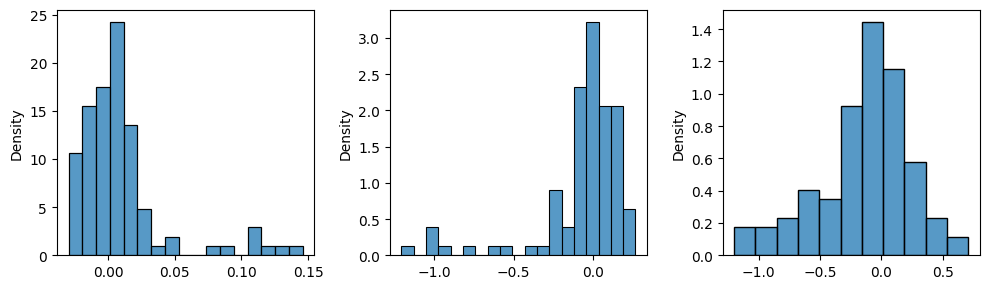

In [28]:
from seaborn import histplot
fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)

histplot(res[:,0],ax=ax[0], stat='density')
histplot(res[:,1],ax=ax[1], stat='density')
histplot(res[:,2],ax=ax[2], stat='density')

In [46]:
sbi_posterior = pickle.load(open(f'posteriors/sbi_collective_posterior_chuong_10k.pkl', 'rb'))

res = np.zeros((100,3))
for i in range(len(thetas)):
    theta = thetas[i]
    Xs = simulator(np.array(theta))
    m = sbi_posterior.set_default_x(Xs).sample((500,)).mean(0)
    res[i] = m - theta
    print(i)



Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

0


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

1


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

2


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

3


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

4


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

5


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

6


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

7


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

8


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

9


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

10


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

11


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

12


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

13


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

14


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

15


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

16


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

17


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

18


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

19


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

20


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

21


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

22


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

23


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

24


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

25


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

26


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

27


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

28


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

29


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

30


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

31


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

32


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

33


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

34


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

35


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

36


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

37


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

38


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

39


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

40


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

41


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

42


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

43


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

44


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

45


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

46


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

47


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

48


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

49


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

50


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

51


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

52


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

53


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

54


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

55


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

56


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

57


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

58


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

59


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

60


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

61


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

62


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

63


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

64


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

65


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

66


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

67


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

68


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

69


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

70


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

71


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

72


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

73


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

74


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

75


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

76


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

77


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

78


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

79


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

80


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

81


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

82


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

83


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

84


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

85


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

86


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

87


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

88


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

89


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

90


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

91


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

92


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

93


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

94


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

95


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

96


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

97


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

98


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

99


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

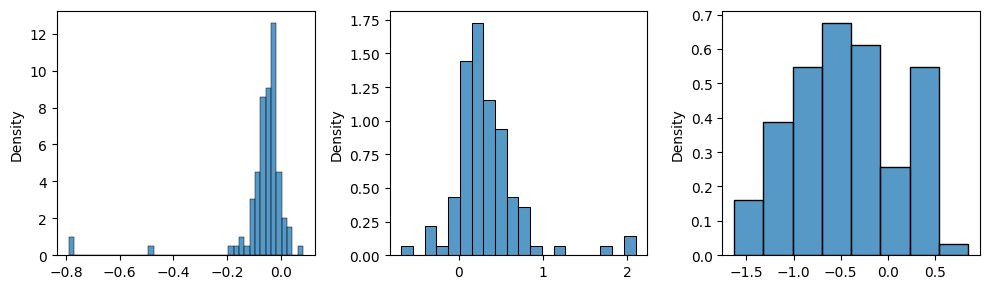

In [47]:
fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)

histplot(res[:,0],ax=ax[0], stat='density')
histplot(res[:,1],ax=ax[1], stat='density')
histplot(res[:,2],ax=ax[2], stat='density')